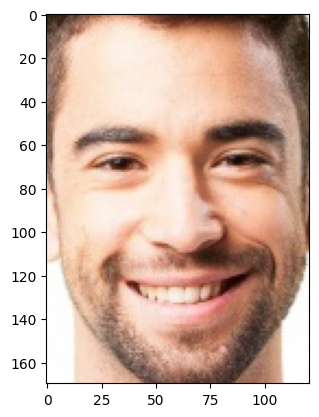

In [8]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os
import cvlib as cv
import matplotlib.pyplot as plt
                    


# Define the path to the image file
image_path = r"D:\genderdataset\man\face_0.jpg"

img_bgr = cv2.imread(image_path)

# Check if the image was loaded successfully
if img_bgr is None:
    print("Error: Image could not be loaded.")
else:
    # Convert the image from BGR to RGB
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    # Display the RGB image
    plt.imshow(img_rgb)
    plt.axis('on')  # Turn off axis numbers and ticks
    plt.show()



In [21]:
img_rgb.shape

(170, 121, 3)

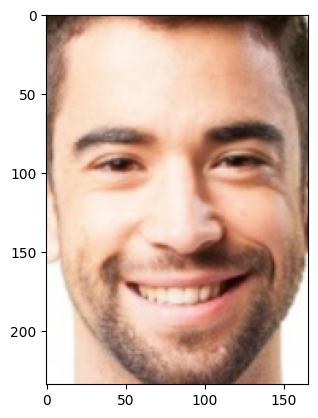

In [10]:
new_height = 234
scale = new_height / img_rgb.shape[0]
new_width = int(img_rgb.shape[1] * scale)
resized_img = cv2.resize(img_rgb, (new_width, new_height))

# Display the resized image
plt.imshow(resized_img)
plt.axis('on')
plt.show()

In [11]:
resized_img.shape

(234, 166, 3)

In [12]:
def resize_images_in_folder(folder_path, target_height=234, target_width=234):
    images = []
    labels = []
    
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                
                # Read the image
                img_bgr = cv2.imread(img_path)
                if img_bgr is None:
                    continue
                
                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
                
                # Get the current dimensions of the image
                height, width = img_rgb.shape[:2]
                
                # Calculate the scale to resize the image while maintaining aspect ratio
                scale = target_height / height
                new_width = int(width * scale)
                
                # Resize the image
                resized_img = cv2.resize(img_rgb, (new_width, target_height))
                
                # Pad or crop the image to ensure it has the target width
                if new_width < target_width:
                    # Padding
                    pad_width = target_width - new_width
                    left_pad = pad_width // 2
                    right_pad = pad_width - left_pad
                    padded_img = cv2.copyMakeBorder(resized_img, 0, 0, left_pad, right_pad, cv2.BORDER_CONSTANT, value=(0, 0, 0))
                elif new_width > target_width:
                    # Cropping
                    start_x = (new_width - target_width) // 2
                    cropped_img = resized_img[:, start_x:start_x + target_width]
                    padded_img = cropped_img
                else:
                    padded_img = resized_img
                
                # Convert to numpy array and append to list
                images.append(padded_img)
                
                # Determine label based on the folder name
                label = os.path.basename(os.path.dirname(img_path))
                labels.append(1 if label == "woman" else 0)
    
    # Convert lists to numpy arrays
    images = np.array(images, dtype="float") / 255.0
    labels = np.array(labels)
    
    return images, labels

# Define the path to the gender dataset folder
folder_path = r"D:\genderdataset"

# Resize images and get the numpy arrays
images, labels = resize_images_in_folder(folder_path)

print(f"Resized images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Resized images shape: (2307, 234, 234, 3)
Labels shape: (2307,)


In [13]:
import os
import shutil
from pathlib import Path
from send2trash import send2trash
import scipy

#imports for CNN
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.preprocessing import image
from keras import optimizers

In [14]:
print(tf.test.is_gpu_available)

<function is_gpu_available at 0x00000193FF84B9C0>


In [15]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# data preprocessing
We have to seperate the images into training and testing sets in different folders to faciliate the ImageDataGenerator to work

In [16]:
from pathlib import Path
import os

# Setting up the directories
src_dir = Path(Path.cwd()).joinpath('data')
root_dir = Path(Path.cwd())

root_men_dir = os.path.join("D:\\genderdataset\\man")
root_women_dir = os.path.join("D:\\genderdataset\\woman")


In [17]:
import os
from pathlib import Path

# Recreates a fresh directory
src_dir = Path(Path.cwd()).joinpath('data')

if os.path.exists(src_dir):
    send2trash(str(src_dir))

os.mkdir(src_dir)

os.mkdir(src_dir.joinpath('train'))
os.mkdir(src_dir.joinpath('test'))
os.mkdir(src_dir.joinpath('validate'))

os.mkdir(src_dir.joinpath('train', 'men'))
os.mkdir(src_dir.joinpath('train', 'women'))

os.mkdir(src_dir.joinpath('test', 'men'))
os.mkdir(src_dir.joinpath('test', 'women'))

os.mkdir(src_dir.joinpath('validate', 'men'))
os.mkdir(src_dir.joinpath('validate', 'women'))


In [122]:
import os
import numpy as np

# Ratio for splitting
split_ratio = 0.2
train_ratio = 1 - split_ratio
val_test_ratio = split_ratio / 2  # Since validation and test are equal

# For men
all_files = os.listdir(root_men_dir)
np.random.shuffle(all_files)

train_FileNames, temp_FileNames = np.split(np.array(all_files), [int(len(all_files) * train_ratio)])
validation_FileNames, test_FileNames = np.split(temp_FileNames, [int(len(temp_FileNames) * 0.5)])

print("*" * 40)
print("Men Data")
print("all_files number is \t\t" + str(len(all_files)))
print("train_FileNames number is \t" + str(len(train_FileNames)))
print("test_FileNames number is \t" + str(len(test_FileNames)))
print("validation_FileNames number is \t" + str(len(validation_FileNames)))
print("*" * 40, '\n')

# For women
all_files = os.listdir(root_women_dir)
np.random.shuffle(all_files)

w_train_FileNames, w_temp_FileNames = np.split(np.array(all_files), [int(len(all_files) * train_ratio)])
w_validation_FileNames, w_test_FileNames = np.split(w_temp_FileNames, [int(len(w_temp_FileNames) * 0.5)])

print("*" * 40)
print("Women Data")
print("all_files number is \t\t" + str(len(all_files)))
print("train_FileNames number is \t" + str(len(w_train_FileNames)))
print("test_FileNames number is \t" + str(len(w_test_FileNames)))
print("validation_FileNames number is \t" + str(len(w_validation_FileNames)))
print("*" * 40)


****************************************
Men Data
all_files number is 		1173
train_FileNames number is 	938
test_FileNames number is 	118
validation_FileNames number is 	117
**************************************** 

****************************************
Women Data
all_files number is 		1134
train_FileNames number is 	907
test_FileNames number is 	114
validation_FileNames number is 	113
****************************************


In [22]:
#Copying files over to folders
for i, name in enumerate(train_FileNames):
    shutil.copy(str(root_men_dir)+'/'+name, str(src_dir.joinpath('train','men','man')) + str(i) +'.jpg')

for i, name in enumerate(validation_FileNames):
    shutil.copy(str(root_men_dir)+'/'+name, str(src_dir.joinpath('validate','men','man')) + str(i) +'.jpg')

for i, name in enumerate(test_FileNames):
    shutil.copy(str(root_men_dir)+'/'+name, str(src_dir.joinpath('test','men','man')) + str(i) +'.jpg')

for i, name in enumerate(w_train_FileNames):
    shutil.copy(str(root_women_dir)+'/'+name, str(src_dir.joinpath('train','women','woman')) + str(i) +'.jpg')

for i, name in enumerate(w_validation_FileNames):
    shutil.copy(str(root_women_dir)+'/'+name, str(src_dir.joinpath('validate','women','woman')) + str(i) +'.jpg')

for i, name in enumerate(w_test_FileNames):
    shutil.copy(str(root_women_dir)+'/'+name, str(src_dir.joinpath('test','women','woman')) + str(i) +'.jpg')

In [23]:
#Checking if the number of pictures are correct / consistent
print('number of pictures in the training man is \t' , len(os.listdir(src_dir.joinpath('train','men'))))
print('number of pictures in the validate man is \t' , len(os.listdir(src_dir.joinpath('validate','men'))))
print('number of pictures in the test man is \t\t' , len(os.listdir(src_dir.joinpath('test','men'))))
print('number of pictures in the training women is \t' , len(os.listdir(src_dir.joinpath('train','women'))))
print('number of pictures in the validate women is \t' , len(os.listdir(src_dir.joinpath('validate','women'))))
print('number of pictures in the test women is \t' , len(os.listdir(src_dir.joinpath('test','women'))))

number of pictures in the training man is 	 938
number of pictures in the validate man is 	 117
number of pictures in the test man is 		 118
number of pictures in the training women is 	 907
number of pictures in the validate women is 	 113
number of pictures in the test women is 	 114


In [25]:
import tensorflow as tf
from pathlib import Path

train_dir = str(src_dir.joinpath('train'))
validation_dir = str(src_dir.joinpath('validate'))
test_dir = str(src_dir.joinpath('test'))
batch_size = 20
img_size = (150, 150)


In [26]:
def augment_image(image):
    image = tf.image.resize(image, img_size)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_rotation(image, 0.2)
    return image


In [32]:
from tensorflow.keras.preprocessing import image


In [33]:
train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validate_datagen = image.ImageDataGenerator(
    rescale=1./255)

test_datagen = image.ImageDataGenerator(
    rescale=1./255)


# modelling time 
Here we put the images into an image data generator so that when we call fit generator later on, the images will flow from our directory into the model.

We use some data augmentation to make the model more robust

In [34]:
from tensorflow.keras.preprocessing import image

train_dir = src_dir.joinpath('train')
validation_dir = src_dir.joinpath('validate')
test_dir = src_dir.joinpath('test')

train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validate_datagen = image.ImageDataGenerator(
    rescale=1./255)

test_datagen = image.ImageDataGenerator(
    rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = validate_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    shuffle=False)


Found 1845 images belonging to 2 classes.
Found 230 images belonging to 2 classes.
Found 232 images belonging to 2 classes.


In [35]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(32,(3,3),activation = 'relu', input_shape = (150,150,3)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4)
)


In [39]:
history = model.fit(train_generator, 
                    steps_per_epoch=100, 
                    epochs=30, 
                    validation_data= validation_generator, 
                    validation_steps=10, 
                    shuffle = True)

Epoch 1/30


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 93/100 ━━━━━━━━━━━━━━━━━━━━ 4s 587ms/step - accuracy: 0.5500 - loss: 0.6910

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 582ms/step - accuracy: 0.5498 - loss: 0.6909 - val_accuracy: 0.7200 - val_loss: 0.6749
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 399ms/step - accuracy: 0.6079 - loss: 0.6761 - val_accuracy: 0.7333 - val_loss: 0.6015
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 409ms/step - accuracy: 0.6333 - loss: 0.6413 - val_accuracy: 0.7650 - val_loss: 0.5553
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 421ms/step - accuracy: 0.6593 - loss: 0.6166 - val_accuracy: 0.8667 - val_loss: 0.3880
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 415ms/step - accuracy: 0.7058 - loss: 0.5591 - val_accuracy: 0.7650 - val_loss: 0.4777
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 401ms/step - accuracy: 0.7349 - loss: 0.5364 - val_accuracy: 0.7333 - val_loss: 0.5160
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 416ms/step - accuracy: 0.7506 - loss: 0.5149 - val_accuracy: 0.8300 - val_loss: 0.4051
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 395ms/step - accuracy: 0.7700 - loss: 0.4773 - val

In [45]:
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(10,10))
    plt.plot(epochs, acc, 'b--', label="Training accuracy")
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.figure(figsize=(10,10))
    plt.plot(epochs, loss, 'b--', label="Training loss")
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


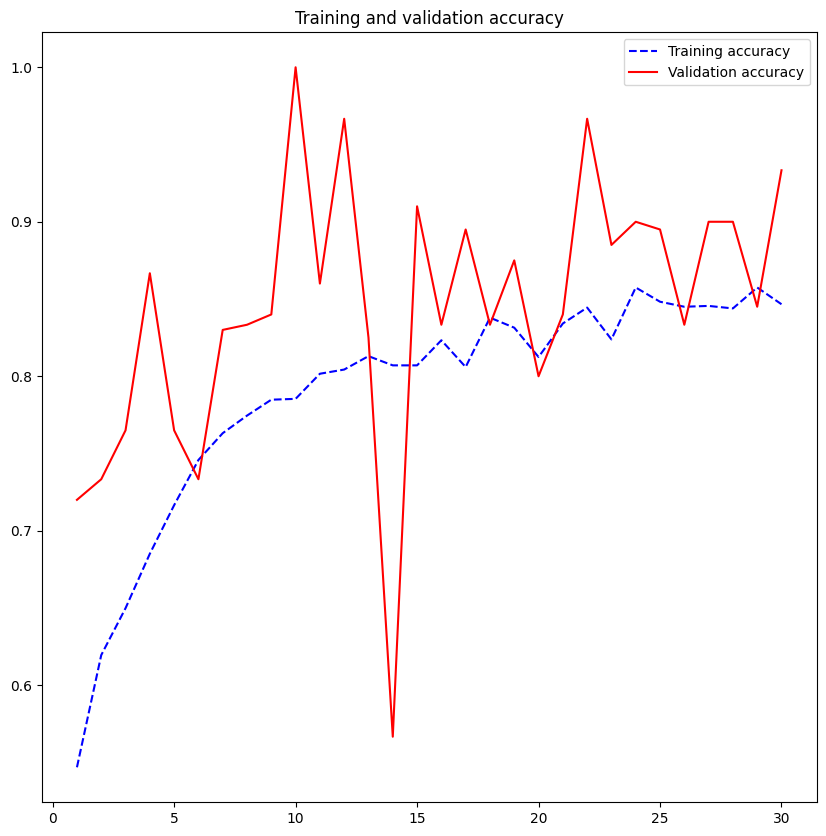

<Figure size 640x480 with 0 Axes>

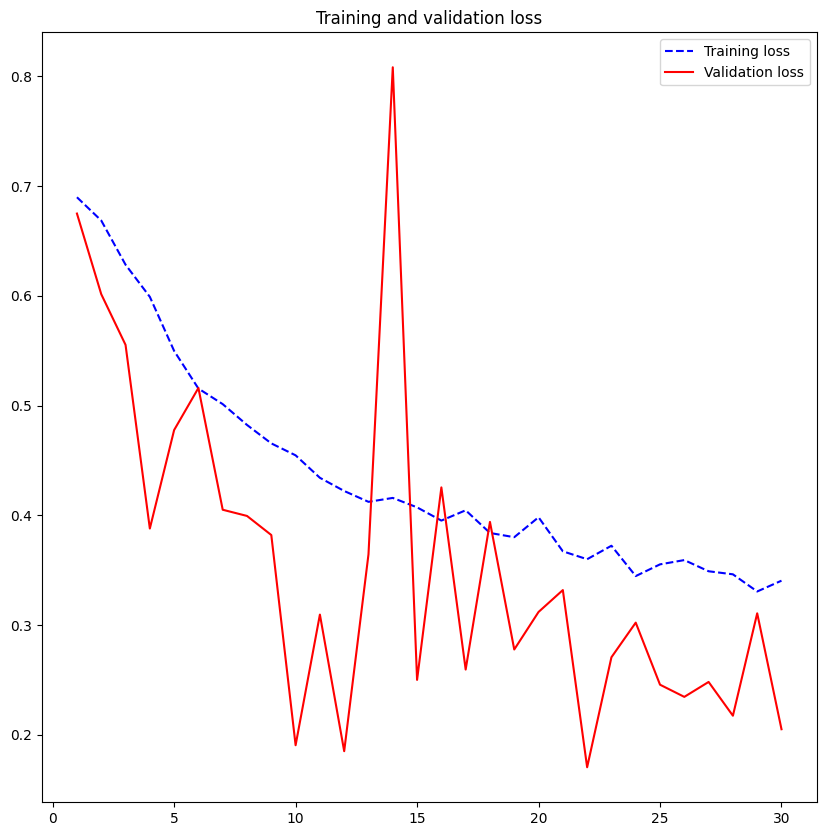

In [46]:
plot_results(history)

In [82]:
print(model.built)

True


In [83]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 175232)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │         175,233 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 176,129 (688.00 KB)

 Trainable params: 176,129 (688.00 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
print(model.layers[0].input)

<KerasTensor shape=(None, 150, 150, 3), dtype=float32, sparse=False, name=keras_tensor_92>


In [86]:
all_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs=model.layers[0].input, outputs=all_outputs)

In [89]:
for i, layer_output in enumerate(activation_model.predict(samples[0])):
    print(f"Layer {i} output shape: {layer_output.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Layer 0 output shape: (1, 148, 148, 32)
Layer 1 output shape: (1, 74, 74, 32)
Layer 2 output shape: (1, 175232)
Layer 3 output shape: (1, 1)


# visualising features of cnn
We will now take a look at the early layers to see what each layer is picking up on

Found 1845 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


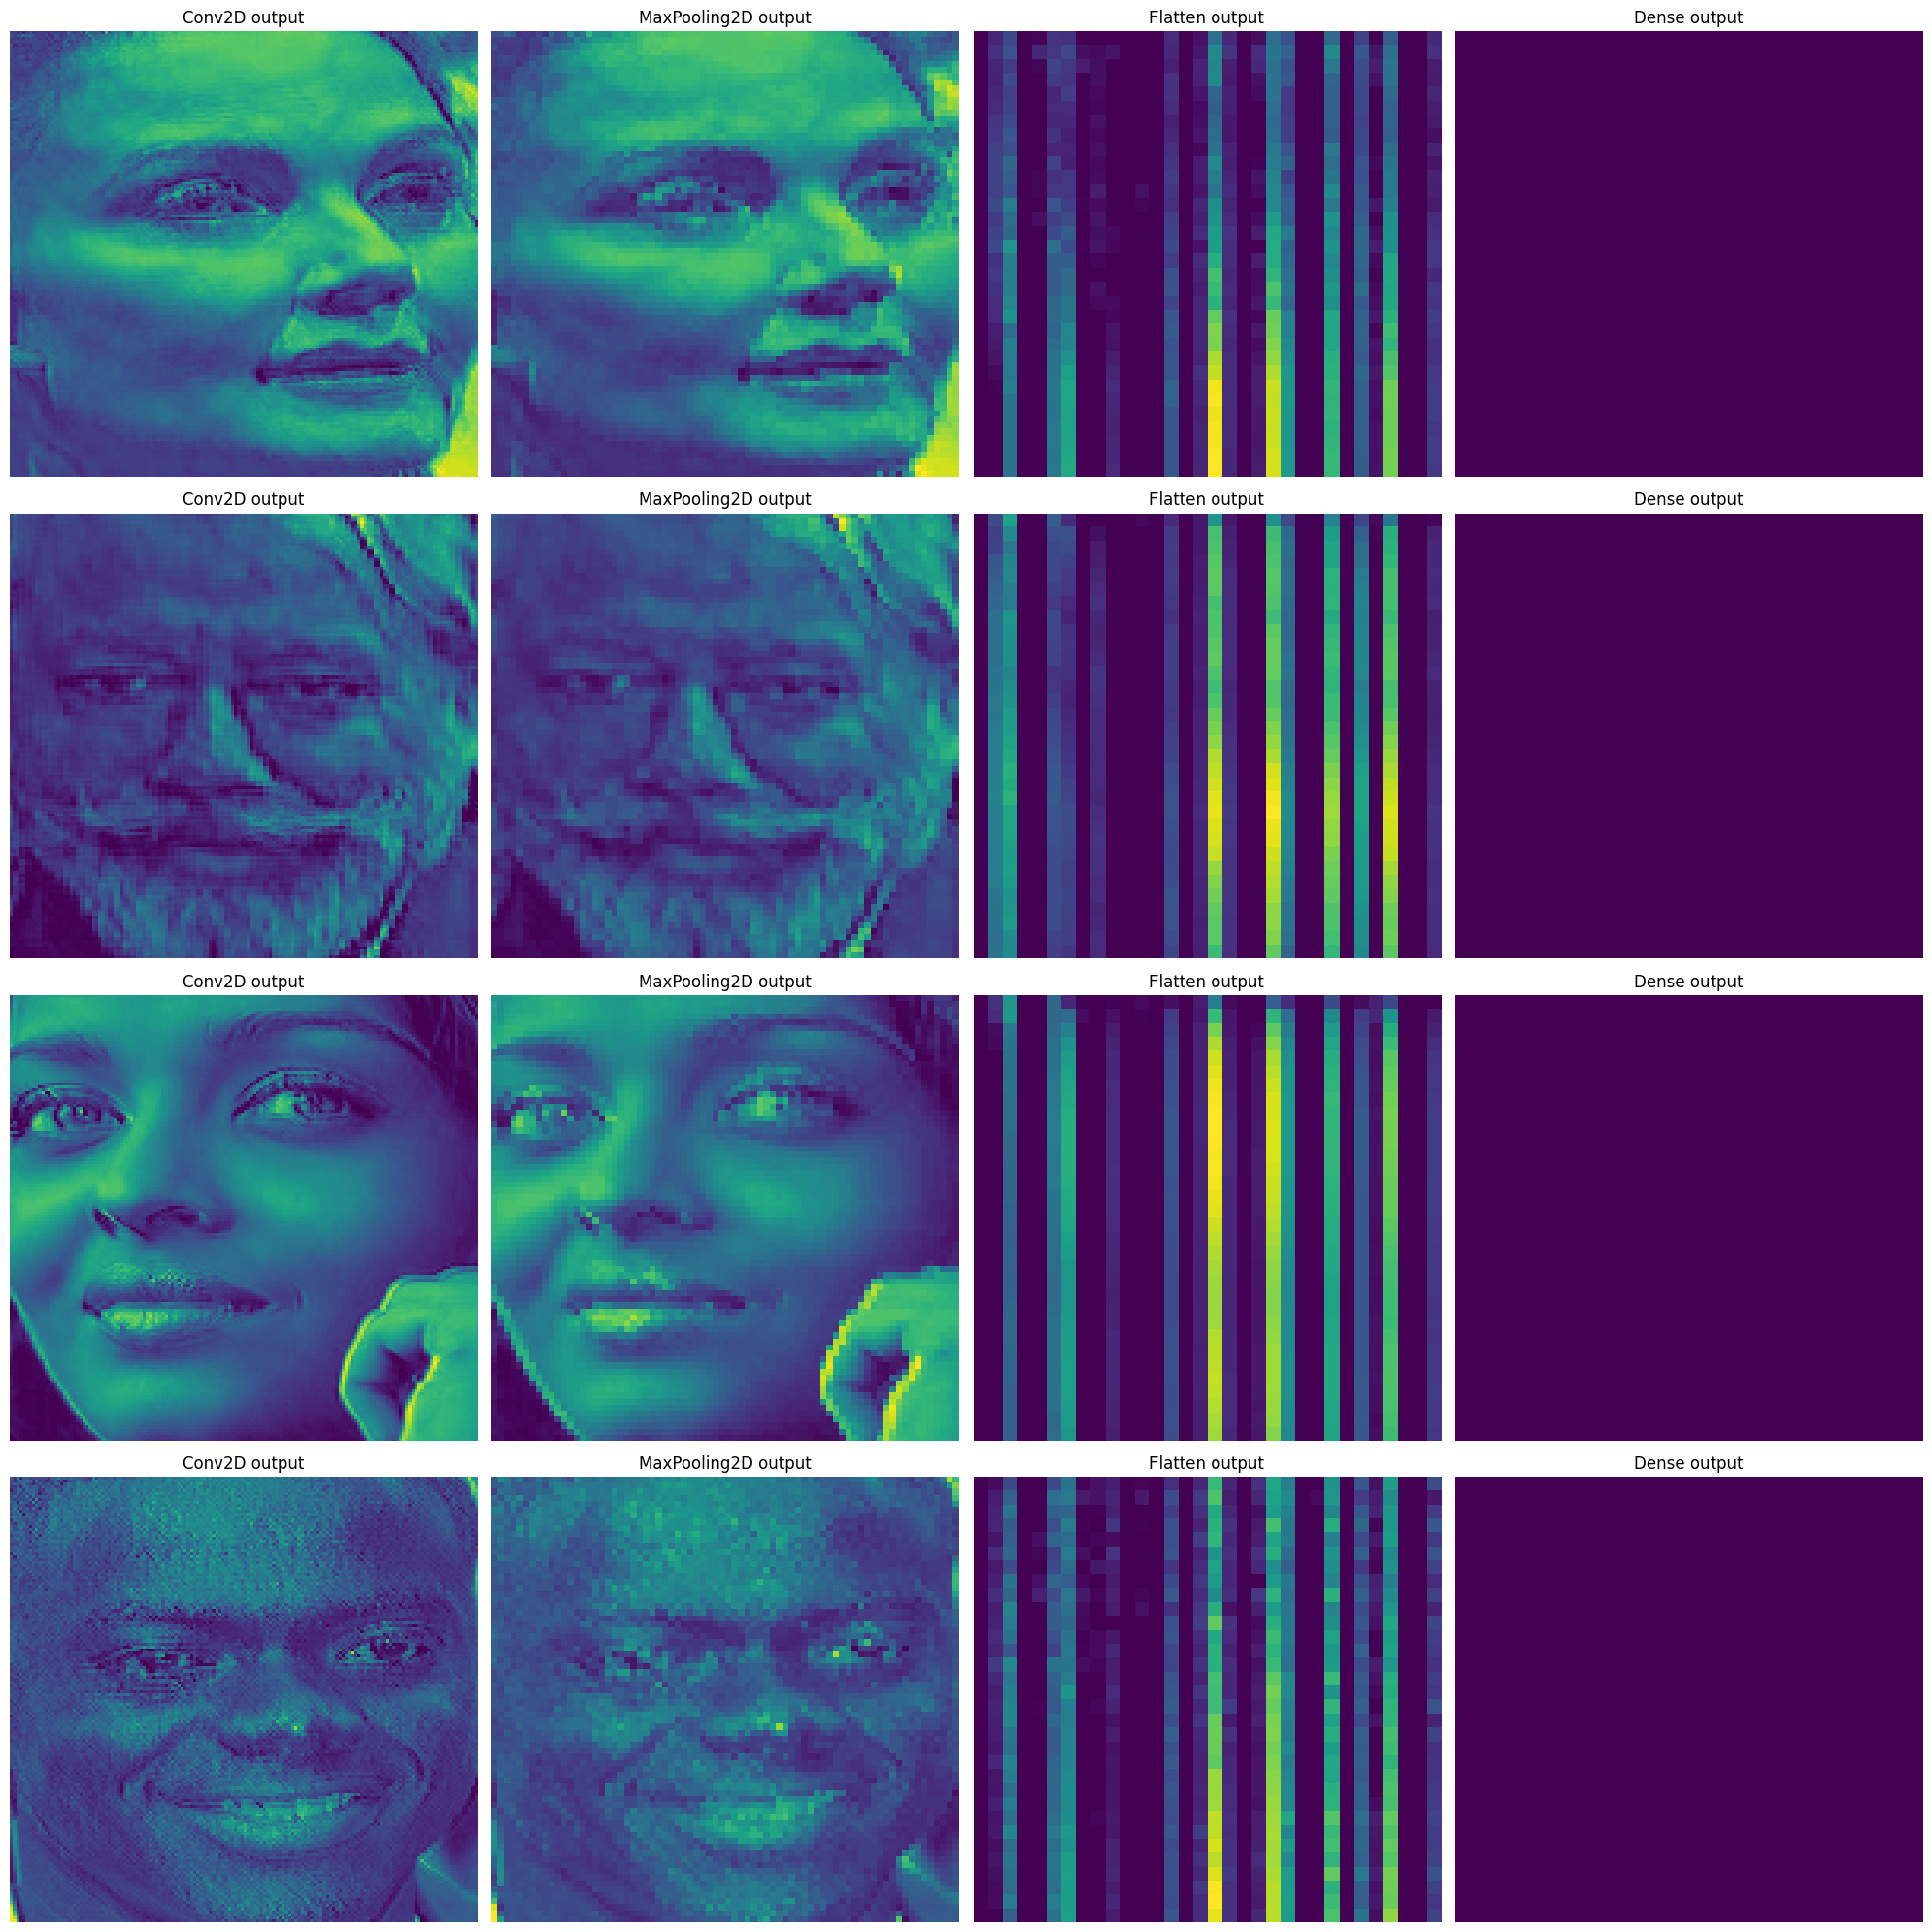

In [93]:
import numpy as np
import matplotlib.pyplot as plt

feature_number = 5  # We'll use this for the convolutional layers
sample_generator = image.ImageDataGenerator(rescale=1./255)
sample_datagen = sample_generator.flow_from_directory(train_dir,
                                                      target_size=(150, 150),
                                                      batch_size=1,
                                                      class_mode='binary')
samples = [np.array(next(sample_datagen)[0]).reshape(1, 150, 150, 3) for _ in range(4)]

fig, axes = plt.subplots(4, 4, figsize=(20, 20))

layer_names = ['Conv2D', 'MaxPooling2D', 'Flatten', 'Dense']

for i, sample in enumerate(samples):
    activations = activation_model.predict(sample)
    for j, activation in enumerate(activations):
        if j == 0 or j == 1:  # Conv2D and MaxPooling2D layers
            display = activation[0, :, :, feature_number]
        elif j == 2:  # Flatten layer
            # Display the activation as a 1D array if reshaping fails
            display = activation[0]
            if display.size > 1000:
                # Display a grid of size 32x32 if possible
                side_length = int(np.sqrt(display.size))
                if side_length**2 == display.size:
                    display = display.reshape((side_length, side_length))
                else:
                    # Limit display size for better visualization
                    display = display[:1024]  # First 1024 values
                    display = display.reshape((32, 32))
            else:
                # If the flattened size is small, display it fully
                display = display.reshape((1, -1))
        else:  # Dense layer
            display = activation[0].reshape((1, 1))
        
        axes[i, j].imshow(display, cmap='viridis', aspect='auto')
        axes[i, j].set_title(f'{layer_names[j]} output')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()


In [94]:
all_outputs

[<KerasTensor shape=(None, 148, 148, 32), dtype=float32, sparse=False, name=keras_tensor_93>,
 <KerasTensor shape=(None, 74, 74, 32), dtype=float32, sparse=False, name=keras_tensor_94>,
 <KerasTensor shape=(None, 175232), dtype=float32, sparse=False, name=keras_tensor_95>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_96>]

In [99]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input
from tensorflow.keras.models import Model

# Define the model using subclassing
class CustomModel(tf.keras.Model):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv = Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3))
        self.flatten = Flatten()
        self.dense = Dense(1, activation='sigmoid')
    
    def call(self, inputs):
        x = self.conv(inputs)
        x = self.flatten(x)
        return self.dense(x)

# Create the model instance
model = CustomModel()

# Build the model explicitly with input shape
model.build((None, 150, 150, 3))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Try accessing the input tensor via the model's functional API
inputs = Input(shape=(150, 150, 3))
outputs = model(inputs)  # This should force the model to build
model = Model(inputs, outputs)

# Access the input tensor after forcing the model to build
try:
    input_tensor = model.input
    print(input_tensor)
except Exception as e:
    print(f"Error accessing input tensor: {e}")

# Print the model summary to verify the structure
model.summary()


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'custom_model_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



<KerasTensor shape=(None, 150, 150, 3), dtype=float32, sparse=False, name=keras_tensor_111>


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_model_1 (CustomModel)         │ (None, 1)                   │         701,825 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 701,825 (2.68 MB)

 Trainable params: 701,825 (2.68 MB)

 Non-trainable params: 0 (0.00 B)

In [102]:
from keras.preprocessing import image
from pathlib import Path
import numpy as np

# Corrected path with raw string notation
img = image.load_img(path=Path(r"D:\genderdataset\woman\face_0.jpg"), target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


C:\Users\HP\AppData\Local\Temp\ipykernel_29392\2404272503.py:30: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
C:\Users\HP\AppData\Local\Temp\ipykernel_29392\2404272503.py:33: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


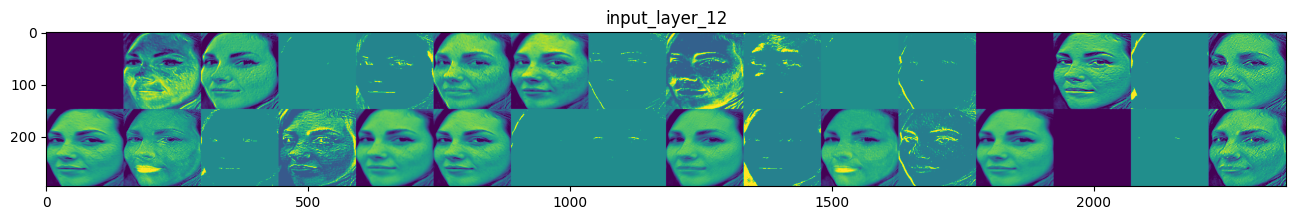

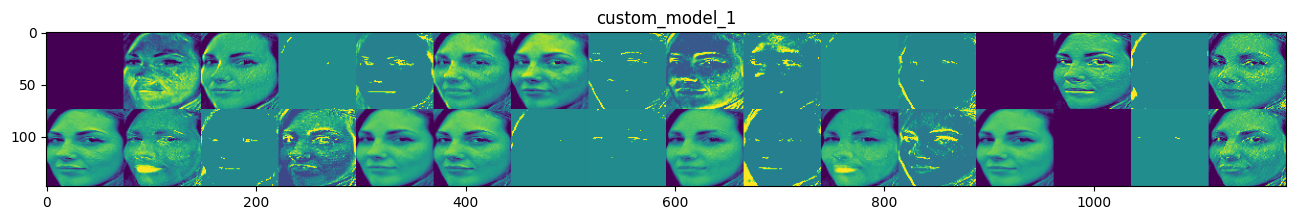

In [103]:
#Visualisation of the feature layers - code taken from Francois Deep Learning Example 

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

In [104]:
def load_image(filename):
    img = image.load_img(filename, grayscale=True, target_size=(150, 150))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

In [105]:
predictions = model.predict(test_generator)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step


In [106]:
predictions.shape

(232, 1)

In [112]:
model.metrics_names

['loss', 'loss', 'compile_metrics', 'compile_metrics']

In [113]:
from sklearn.metrics import classification_report

In [114]:
len(predictions)

232

In [115]:
print('number of pictures in the test man is \t\t' , len(os.listdir(src_dir.joinpath('test','men'))))
print('number of pictures in the test women is \t' , len(os.listdir(src_dir.joinpath('test','women'))))

number of pictures in the test man is 		 118
number of pictures in the test women is 	 114


In [116]:
predicted_classes= predictions > 0.5
predicted_classes = predicted_classes.astype('int')

In [117]:
filenames = test_generator.filenames
total_prediction = []
for f in range(len(filenames)):
    print(filenames[f],":",predicted_classes[f])
    total_prediction.append([filenames[f],predicted_classes[f]])

men\man0.jpg : [1]
men\man1.jpg : [0]
men\man10.jpg : [0]
men\man100.jpg : [1]
men\man101.jpg : [0]
men\man102.jpg : [0]
men\man103.jpg : [1]
men\man104.jpg : [0]
men\man105.jpg : [0]
men\man106.jpg : [1]
men\man107.jpg : [1]
men\man108.jpg : [1]
men\man109.jpg : [0]
men\man11.jpg : [0]
men\man110.jpg : [0]
men\man111.jpg : [0]
men\man112.jpg : [0]
men\man113.jpg : [0]
men\man114.jpg : [0]
men\man115.jpg : [0]
men\man116.jpg : [0]
men\man117.jpg : [0]
men\man12.jpg : [0]
men\man13.jpg : [0]
men\man14.jpg : [0]
men\man15.jpg : [0]
men\man16.jpg : [0]
men\man17.jpg : [1]
men\man18.jpg : [0]
men\man19.jpg : [0]
men\man2.jpg : [0]
men\man20.jpg : [0]
men\man21.jpg : [1]
men\man22.jpg : [0]
men\man23.jpg : [0]
men\man24.jpg : [0]
men\man25.jpg : [0]
men\man26.jpg : [0]
men\man27.jpg : [0]
men\man28.jpg : [0]
men\man29.jpg : [0]
men\man3.jpg : [0]
men\man30.jpg : [0]
men\man31.jpg : [0]
men\man32.jpg : [1]
men\man33.jpg : [1]
men\man34.jpg : [0]
men\man35.jpg : [1]
men\man36.jpg : [0]
men\ma

In [119]:
print(len(y_true))
print(len(y_pred))


334
232


In [125]:
# men 142 images
# women 192 images
y_true = np.array([0] * 118 + [1] * 114)
y_pred = predicted_classes

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.77      0.59       118
           1       0.33      0.11      0.17       114

    accuracy                           0.45       232
   macro avg       0.40      0.44      0.38       232
weighted avg       0.40      0.45      0.38       232



# transfer learning
We shall use VGG16

In [126]:
from tensorflow.keras.applications import VGG16

In [127]:
vgg_model = VGG16(weights = 'imagenet' , 
                                include_top = False,
                                input_shape = (150,150,3))

for layer in vgg_model.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [128]:
vgg_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [129]:
last_layer = vgg_model.get_layer('block5_pool')
output = last_layer.output

x = tf.keras.layers.Flatten()(output)
x = tf.keras.layers.Dense(512,activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

In [130]:
transfer_learning_model = tf.keras.models.Model(vgg_model.input, x)

In [131]:
transfer_learning_model.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 18,910,017 (72.14 MB)

 Trainable params: 4,195,329 (16.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [133]:
import tensorflow as tf

# Corrected optimizer with 'learning_rate' instead of 'lr'
transfer_learning_model.compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],  # Updated metric name
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4)
)


In [134]:
transfer_learning_model_history = transfer_learning_model.fit(train_generator, 
                                                                steps_per_epoch=100, 
                                                                epochs=10, 
                                                                validation_data= validation_generator, 
                                                                validation_steps=10, 
                                                                shuffle = True)

Epoch 1/10
 93/100 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6721 - loss: 0.6009

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


100/100 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.6774 - loss: 0.5939 - val_accuracy: 0.7950 - val_loss: 0.3640
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.8352 - loss: 0.3803 - val_accuracy: 0.8667 - val_loss: 0.2898
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.8416 - loss: 0.3578 - val_accuracy: 0.8950 - val_loss: 0.2409
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.8618 - loss: 0.3074 - val_accuracy: 0.9667 - val_loss: 0.1498
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.8759 - loss: 0.2941 - val_accuracy: 0.8700 - val_loss: 0.2540
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2029s 20s/step - accuracy: 0.8836 - loss: 0.2777 - val_accuracy: 0.8667 - val_loss: 0.3133
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.8754 - loss: 0.2765 - val_accuracy: 0.9100 - val_loss: 0.2425
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.8923 - loss: 0.2511 - val_accuracy: 0.9

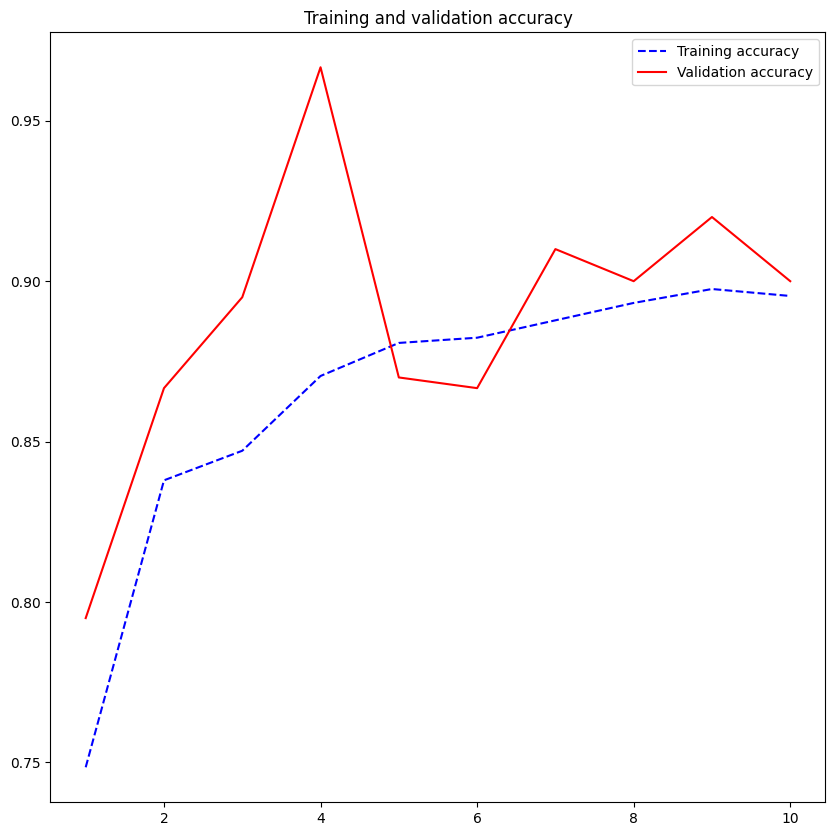

<Figure size 640x480 with 0 Axes>

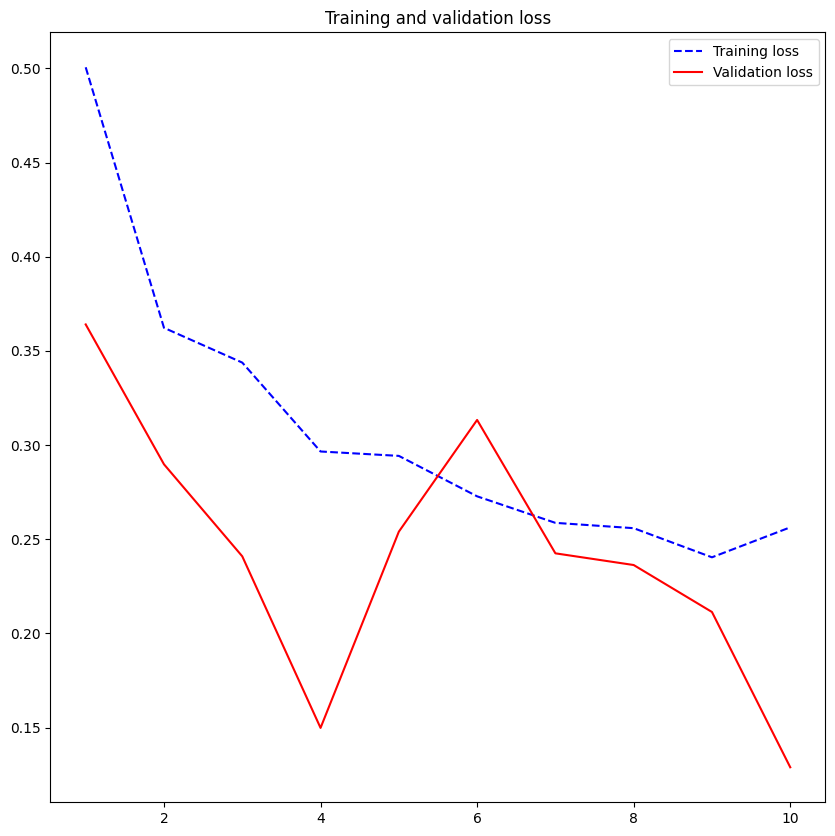

In [135]:
plot_results(transfer_learning_model_history)

In [136]:
for layer in transfer_learning_model.layers[:-7]:
    layer.trainable = True

In [138]:
transfer_learning_model.compile(
    loss='binary_crossentropy',
    metrics=['acc'],
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-6)
)


In [139]:
transfer_learning_model_history = transfer_learning_model.fit(train_generator, 
                    steps_per_epoch=100, 
                    epochs=10, 
                    validation_data= validation_generator, 
                    validation_steps=10, 
                    shuffle = True)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 338s 3s/step - acc: 0.9188 - loss: 0.1963 - val_acc: 0.9350 - val_loss: 0.1675
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 350s 3s/step - acc: 0.9286 - loss: 0.1792 - val_acc: 0.9000 - val_loss: 0.1532
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 345s 3s/step - acc: 0.9276 - loss: 0.1753 - val_acc: 0.9300 - val_loss: 0.1622
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 334s 3s/step - acc: 0.9309 - loss: 0.1767 - val_acc: 0.9667 - val_loss: 0.2270
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 646s 6s/step - acc: 0.9322 - loss: 0.1671 - val_acc: 0.9400 - val_loss: 0.1619
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 336s 3s/step - acc: 0.9419 - loss: 0.1405 - val_acc: 0.9333 - val_loss: 0.0774
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 625s 6s/step - acc: 0.9312 - loss: 0.1687 - val_acc: 0.9300 - val_loss: 0.1691
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 329s 3s/step - acc: 0.9550 - loss: 0.1201 - val_acc: 1.0000 - val_loss: 0.0060
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 776s 8s/

In [140]:
transfer_learning_model_history.history.keys()

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])

In [146]:
def plot_results(history):
    acc = history.history['acc']  # Changed from 'accuracy' to 'acc'
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()


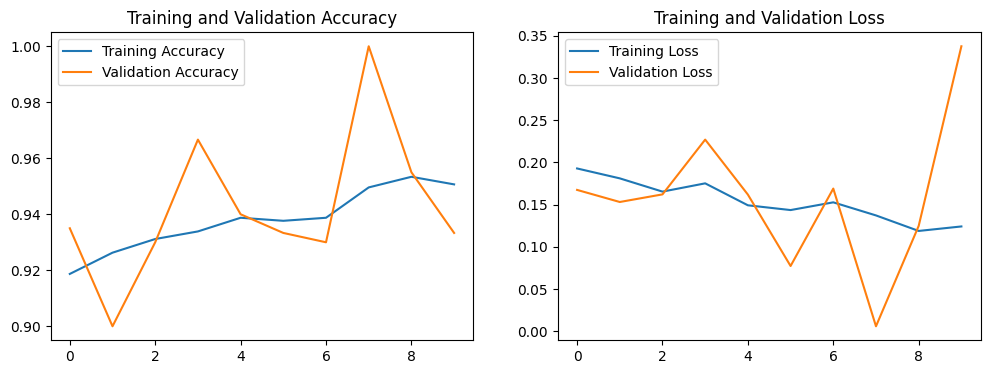

In [147]:
plot_results(transfer_learning_model_history)

In [149]:
predictions = transfer_learning_model.predict(test_generator)
len(predictions)

12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 984ms/step


232

In [150]:
print('number of pictures in the test man is \t\t' , len(os.listdir(src_dir.joinpath('test','men'))))
print('number of pictures in the test women is \t' , len(os.listdir(src_dir.joinpath('test','women'))))

number of pictures in the test man is 		 118
number of pictures in the test women is 	 114


In [151]:
predicted_classes= predictions > 0.5
predicted_classes = predicted_classes.astype('int')

In [152]:
filenames = test_generator.filenames
total_prediction = []
for f in range(len(filenames)):
    print(filenames[f],":",predicted_classes[f])
    total_prediction.append([filenames[f],predicted_classes[f]])

men\man0.jpg : [0]
men\man1.jpg : [0]
men\man10.jpg : [0]
men\man100.jpg : [0]
men\man101.jpg : [0]
men\man102.jpg : [0]
men\man103.jpg : [0]
men\man104.jpg : [0]
men\man105.jpg : [0]
men\man106.jpg : [0]
men\man107.jpg : [0]
men\man108.jpg : [0]
men\man109.jpg : [0]
men\man11.jpg : [0]
men\man110.jpg : [0]
men\man111.jpg : [0]
men\man112.jpg : [0]
men\man113.jpg : [0]
men\man114.jpg : [0]
men\man115.jpg : [0]
men\man116.jpg : [0]
men\man117.jpg : [0]
men\man12.jpg : [0]
men\man13.jpg : [0]
men\man14.jpg : [0]
men\man15.jpg : [0]
men\man16.jpg : [0]
men\man17.jpg : [0]
men\man18.jpg : [0]
men\man19.jpg : [0]
men\man2.jpg : [0]
men\man20.jpg : [0]
men\man21.jpg : [0]
men\man22.jpg : [0]
men\man23.jpg : [0]
men\man24.jpg : [0]
men\man25.jpg : [0]
men\man26.jpg : [0]
men\man27.jpg : [0]
men\man28.jpg : [0]
men\man29.jpg : [0]
men\man3.jpg : [0]
men\man30.jpg : [0]
men\man31.jpg : [0]
men\man32.jpg : [0]
men\man33.jpg : [0]
men\man34.jpg : [0]
men\man35.jpg : [0]
men\man36.jpg : [0]
men\ma

In [153]:
# men 118 images
# women 114 images
y_true = np.array([0] * 118 + [1] * 114)
y_pred = predicted_classes

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       118
           1       0.97      0.97      0.97       114

    accuracy                           0.97       232
   macro avg       0.97      0.97      0.97       232
weighted avg       0.97      0.97      0.97       232



In [206]:
import os
import tensorflow as tf

# Define the directory path and model filename
directory = r"C:\Users\HP\gender detection"
model_filename = "gender_detection.h5"
model_path = os.path.join(directory, model_filename)

# Save the model
transfer_learning_model.save(model_path)
print(f"Model saved at {model_path}")


Model saved at C:\Users\HP\gender detection\gender_detection.h5


In [190]:
import os

# If you know the filename
filename = "transfer_learning_model.h5"
absolute_path = os.path.abspath(filename)

# Print the absolute path
print("Absolute path:", absolute_path)


Absolute path: C:\Users\HP\gender detection\transfer_learning_model.h5


In [ ]:
import cv2
import numpy as np
import tensorflow as tf

# Correct path to your model file
model_path = r"C:\Users\HP\gender detection\gender_detection.h5"

# Load the trained model
try:
    transfer_learning_model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# Define the input size for the model
input_size = (150, 150)  # Update based on your model's input size

# Define a function to preprocess the frame
def preprocess_frame(frame, input_size):
    # Resize the frame to match the model's input size
    frame_resized = cv2.resize(frame, input_size)
    # Convert the frame to a float32 numpy array
    frame_array = np.array(frame_resized, dtype=np.float32)
    # Normalize the pixel values to [0, 1]
    frame_array /= 255.0
    # Expand dimensions to match the model's input shape (batch_size, height, width, channels)
    frame_array = np.expand_dims(frame_array, axis=0)
    return frame_array

# Open the webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    if not ret:
        print("Error: Could not read frame.")
        break
    
    # Preprocess the frame
    preprocessed_frame = preprocess_frame(frame, input_size)
    
    # Make predictions
    try:
        predictions = transfer_learning_model.predict(preprocessed_frame)
        print(f"Predictions: {predictions}")  # Debug print to see the predictions
    except Exception as e:
        print(f"Error during prediction: {e}")
        break
    
    # Assuming binary classification, where prediction > 0.5 indicates male and <= 0.5 indicates female
    gender = 'Male' if predictions[0] > 0.5 else 'Female'
    
    # Display the resulting frame with the prediction
    cv2.putText(frame, f'Gender: {gender}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
    # Display the frame
    cv2.imshow('Gender Detection', frame)
    
    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close windows
cap.release()
cv2.destroyAllWindows()


Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
Predictions: [[0.5243051]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Predictions: [[0.26608363]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Predictions: [[0.28889665]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Predictions: [[0.16663915]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Predictions: [[0.23874094]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Predictions: [[0.18603629]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Predictions: [[0.20570225]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Predictions: [[0.17095718]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Predictions: [[0.22011779]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Predictions: [[0.19054747]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Predictions: [[0.22192518]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Predictions: [[0.26777986]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Predictions: [[0.35596445]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Predictions: [[0.39180517]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/st